## Imports and global variables

In [81]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import csv

In [103]:
from implementations import *
from helpers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
DATA_FOLDER = "./data/"
TRAIN_FILE = "./train.csv"
TEST_FILE = "./test.csv"

NAN_VALUE = -999.0
INTEGER_COLUMN = (
    22  # 24 in raw csv file, but 23 when id and prediction column are removed
)

# For debug purpose only
SUB_SAMPLE = False
SHOW_GRAPHS = False

# Import dataset

In [84]:
# Load data
x_tr, y_tr = load_data(
    DATA_FOLDER + TRAIN_FILE, sub_sample=SUB_SAMPLE
)  # TODO use the provided method
x_te, y_te = load_data(DATA_FOLDER + TEST_FILE, sub_sample=SUB_SAMPLE)

print("x_tr shape : {}, y_tr shape : {}".format(x_tr.shape, y_tr.shape))
print("x_te shape : {}, y_te shape : {}".format(x_te.shape, y_te.shape))

# Define missing values as NAN
x_tr[x_tr == NAN_VALUE] = np.nan
x_te[x_te == NAN_VALUE] = np.nan

x_tr shape : (250000, 30), y_tr shape : (250000, 1)
x_te shape : (568238, 30), y_te shape : (568238, 1)


# Data exploration

## Labels

Signals: 85667 (34.2668%)
Backgrounds: 164333 (65.7332%)
Ratio signal / background: 0.521301260245964


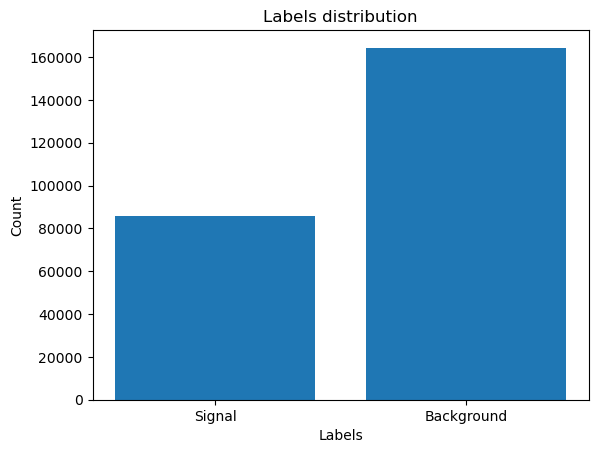

In [85]:
nb_s = len(y_tr[y_tr == 1])
nb_b = len(y_tr) - nb_s
print("Signals: {} ({}%)".format(nb_s, 100 * nb_s / len(x_tr)))
print("Backgrounds: {} ({}%)".format(nb_b, 100 * nb_b / len(x_tr)))
print("Ratio signal / background: {}".format(nb_s / nb_b))

plt.bar(["Signal", "Background"], [nb_s, nb_b])
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Labels distribution")
plt.show()

## NAN values

In [86]:
MAX_NAN_RATIO = 0.5

nb_nan = np.count_nonzero(np.isnan(x_tr), axis=0)
nan_ratio = nb_nan / x_tr.shape[1]


print(
    "Nb Columns with > {:.2f} nan ratio : {}".format(
        MAX_NAN_RATIO, np.count_nonzero(nan_ratio >= MAX_NAN_RATIO)
    )
)

col_names = []
with open(DATA_FOLDER + TRAIN_FILE) as dataset:
    col_names = dataset.readline().split(",")
    nan_col_names = [
        col_name for col_idx, col_name in enumerate(col_names[2:]) if nan_ratio[col_idx]
    ]

    print("Columns with > {:.2f} nan ratio :".format(MAX_NAN_RATIO))
    print(nan_col_names)

Nb Columns with > 0.50 nan ratio : 11
Columns with > 0.50 nan ratio :
['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi']


## Histograms

In [87]:
if SHOW_GRAPHS:
    fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

    fig.suptitle("Histograms of raw features (excluding NAN values)")

    # don't select nan values
    for col_idx in range(len(col_names)-2):
        subplt = axs[col_idx%5, math.floor(col_idx/5)]

        col = x_tr[:, col_idx]
        subplt.hist(col[~np.isnan(col)], bins=100)
        subplt.set_title(col_names[col_idx+2])

    plt.tight_layout()
    plt.show()

## In depth feature analysis

In [88]:
col_names[6]

'DER_deltaeta_jet_jet'

In [89]:
if SHOW_GRAPHS:
    # select the feature to plot
    col_name_to_plot = 'DER_pt_h'
    col_idx_to_plot = get_col_idx(col_name_to_plot, col_names)

    col_to_plot = x_tr[:, col_idx_to_plot].copy()
    print(col_to_plot.shape)

    col_to_plot = np.delete(col_to_plot, (7343), axis=0)
    print(col_to_plot.shape)

    # col_to_plot = col_to_plot[~np.isnan(col_to_plot)]

    # remove potential outliers
    # col_to_plot = col_to_plot[col_to_plot < 1800]

    # plot distribution
    fig, axs = plt.subplots(1, 2)
    axs[0].hist(col_to_plot[~np.isnan(col_to_plot)], bins=100)
    axs[0].set_title(col_name_to_plot)

    col_nan = col_to_plot[~np.isnan(col_to_plot)]
    axs[1].boxplot(col_to_plot[~np.isnan(col_to_plot)])
    axs[1].set_title(col_name_to_plot)

    plt.show()

    print("min: {}, max: {}".format(col_to_plot.min(), col_to_plot.max()))
    print("argmin: {}, argmax: {}".format(col_to_plot.argmin(), col_to_plot.argmax()))

    # Outlier : DER_pt_h : 7343, outlier2 = 68116
    # DER_pt_tot : 7343 again
    # PRI_met : 7343 again
    # features_to_log_transform = ['DER_pt_h', 'DER_pt_tot', 'PRI_met', 'PRI_met_sumet]

Transform the feature

In [90]:
if SHOW_GRAPHS:
    col_to_plot = x_tr[:, col_idx_to_plot].copy()

    # clean
    # col_to_plot = col_to_plot[~np.isnan(col_to_plot)]
    # col_to_plot = col_to_plot[col_to_plot < 1000]

    col_to_plot = np.log(col_to_plot+1)
    # col_to_plot, _,_  = standardize_training(col_to_plot)

    # plot distribution
    fig, axs = plt.subplots(1, 2)
    axs[0].hist(col_to_plot[~np.isnan(col_to_plot)], bins=100)
    axs[0].set_title(col_name_to_plot)

    col_nan = col_to_plot[~np.isnan(col_to_plot)]
    axs[1].boxplot(col_to_plot[~np.isnan(col_to_plot)])
    axs[1].set_title(col_name_to_plot)

    plt.show()

    print("min: {}, max: {}".format(col_to_plot.min(), col_to_plot.max()))
    print("argmin: {}, argmax: {}".format(col_to_plot.argmin(), col_to_plot.argmax()))

Test if the feature follows a power law

In [91]:
# array_cumulative=plt.hist(col_to_plot,bins=100,log=True,cumulative=-1,histtype='step')
# plt.title('Histogram of Population (cumulative)')
# plt.ylabel('# of cantons (in log scale)')
# plt.xlabel('population')
# plt.show()

# plt.loglog(array_cumulative[1][1:],array_cumulative[0])
# plt.title('Histogram of Population (cumulative)')
# plt.ylabel('# of cantons (in log scale)')
# plt.xlabel('population (in log scale)')
# plt.show()


## Problematic features analysis
Some features have been empricially defined as problematic. The problem is that after standardization, those features values will highly differ between the training and the test set, due the the presence of an outliers.
The histograms and statistics below allows us to understand which features are problematic.  
Using this technique, the sample 7343 has been identified as an outlier.

In [92]:
if SHOW_GRAPHS:
    fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

    fig.suptitle("Histograms of train features")

    # don't select nan values
    for col_idx in range(x_tr.shape[1]):
        subplt = axs[col_idx%5, math.floor(col_idx/5)]

        col = x_tr[:, col_idx]
        subplt.hist(col[~np.isnan(col)], bins=100)
        subplt.set_title(col_names[col_idx+2])

    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

    fig.suptitle("Histograms of test features")

    # don't select nan values
    for col_idx in range(x_tr.shape[1]):
        subplt = axs[col_idx%5, math.floor(col_idx/5)]

        col = x_te[:, col_idx]
        subplt.hist(col[~np.isnan(col)], bins=100)
        subplt.set_title(col_names[col_idx+2])


    plt.tight_layout()
    plt.show()

In [93]:
if SHOW_GRAPHS:
    problematic_features = 'DER_mass_MMC', 'DER_mass_vis', 'DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet', 'PRI_tau_eta'

    for col_name in problematic_features:
        col_idx = get_col_idx(col_name, col_names)

        fig, axs = plt.subplots(1, 2)

        # plot train distribution
        col_tr = x_tr[:, col_idx].copy()
        col_tr = col_tr[~np.isnan(col_tr)]

        axs[0].hist(col_tr, bins=100)
        axs[0].set_title("Train {}".format(col_name))

        # plot test distribution
        col_te = x_te[:, col_idx].copy()
        col_te = col_te[~np.isnan(col_te)]

        axs[1].hist(col_te, bins=100)
        axs[1].set_title("Test {}".format(col_name))

        plt.show()

        # basic stats
        print("Train:")
        print("min: {}, max: {}".format(col_tr.min(), col_tr.max()))
        print("argmin: {}, argmax: {}".format(col_tr.argmin(), col_tr.argmax()))

        print("Test:")
        print("min: {}, max: {}".format(col_te.min(), col_te.max()))
        print("argmin: {}, argmax: {}".format(col_te.argmin(), col_te.argmax()))


# Feature engineering / Data cleaning

Remove outliers

In [94]:
detected_outliers = [7343]


print(x_tr.shape)

for sample_row in detected_outliers:
    x_tr = np.delete(x_tr, (sample_row), axis=0)
    y_tr = np.delete(y_tr, (sample_row), axis=0)

print(x_tr.shape)

(250000, 30)
(249999, 30)


Initial range of values

In [95]:
print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))

x_tr range :-18.066 4974.979
x_te range :-19.012 4794.827


### Logarithmic fearture transformation

In [96]:
# TODO : transform the test features too

show_transformation = False

cols_to_log_transform = ['DER_pt_h', 'DER_pt_tot', 'PRI_met', 'PRI_met_sumet']

for col_name in cols_to_log_transform:
    col_idx = get_col_idx(col_name, col_names)
    x_tr[:, col_idx] = np.log(x_tr[:, col_idx] + 1) # +1 to avoid log(0)
    x_te[:, col_idx] = np.log(x_te[:, col_idx] + 1)

    if show_transformation:
        col_to_plot = x_tr[:, col_idx]
        #  plot distribution
        fig, axs = plt.subplots(1, 2)
        axs[0].hist(col_to_plot[~np.isnan(col_to_plot)], bins=20)
        axs[0].set_title(col_name)

        axs[1].boxplot(col_to_plot[~np.isnan(col_to_plot)])
        axs[1].set_title(col_name)

        plt.show()

### Finding degree features and handling them

In [97]:
# IDs degrees columns
IDs_degrees = np.array([17, 20, 22, 27, 30])
# Find degree features and expand them
x_tr = expand_degrees(x_tr, IDs_degrees)
x_te = expand_degrees(x_te, IDs_degrees)

### Remove uniform features

In [98]:
# print("x_tr shape : {}".format(x_tr.shape))
# print("x_te shape : {}".format(x_te.shape))

# uni_features = ['PRI_tau_phi', 'PRI_lep_phi', 'PRI_jet_subleading_phi', 'PRI_jet_leading_phi', 'PRI_met_phi']

# for i, col_name in enumerate(uni_features):
#     col_idx = get_col_idx(col_name, col_names)
#     x_tr = np.delete(x_tr, col_idx-i,  1)
#     x_te = np.delete(x_te, col_idx-i,  1)

# print("x_tr shape : {}".format(x_tr.shape))
# print("x_te shape : {}".format(x_te.shape))

x_tr shape : (249999, 35)
x_te shape : (568238, 35)
x_tr shape : (249999, 30)
x_te shape : (568238, 30)


### Basic transformations
- Remove features which contains too much NAN values, because they don't contain ennough information
- Standardize training df
- Replace missing values

In [99]:
print("Before transformation:")
print("x_tr shape : {}".format(x_tr.shape))
print("x_te shape : {}".format(x_te.shape))
print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))

# Remove columns with too much NAN
nb_nan = np.count_nonzero(np.isnan(x_tr), axis=0)
nan_ratio = nb_nan / x_tr.shape[1]

x_tr = x_tr[:, nan_ratio <= MAX_NAN_RATIO]
x_te = x_te[:, nan_ratio <= MAX_NAN_RATIO]

# Standardize before replacing missing values
x_tr, mean_x, std_x = standardize_training(x_tr, missing_values=True)
# TODO : update it to use the traing values
# x_te = standardize_test(x_te, mean_x, std_x)
x_te, _, _ = standardize_training(x_te, missing_values=True)

print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))

# Replace missing data by the mean
x_tr = replace_nan_by_means(x_tr, mean_data=mean_x)
x_te = replace_nan_by_means(x_te, mean_data=mean_x)

assert(x_tr[np.isnan(x_tr)].shape[0] == 0)
assert(x_te[np.isnan(x_te)].shape[0] == 0)

print("After transformation:")
print("x_tr shape : {}".format(x_tr.shape))
print("x_te shape : {}".format(x_te.shape))
print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))
# TODO : the errors probably comes from huge values in the test set

Before transformation:
x_tr shape : (249999, 30)
x_te shape : (568238, 30)
x_tr range :-18.066 4974.979
x_te range :-19.012 4794.827
x_tr range :-4.778115324322424 32.37988671325263
x_te range :-4.863418048000817 36.42470895701185
After transformation:
x_tr shape : (249999, 20)
x_te shape : (568238, 20)
x_tr range :-4.778115324322424 32.37988671325263
x_te range :-4.863418048000817 36.42470895701185


## Balance dataset

In [104]:
nb_s = len(y_tr[y_tr == 1])
nb_b = len(y_tr) - nb_s
print("Signals: {} ({}%)".format(nb_s, 100 * nb_s / len(x_tr)))
print("Backgrounds: {} ({}%)".format(nb_b, 100 * nb_b / len(x_tr)))
print("Ratio signal / background: {}".format(nb_s / nb_b))

x_tr_ds, y_tr_ds = balance_dataset(x_tr, y_tr)

Signals: 85666 (34.26653706614827%)
Backgrounds: 164333 (65.73346293385174%)
Ratio signal / background: 0.521295175040923


## Analyse test set :

In [ ]:
# ---

## Model fitting

In [105]:
# Use downsampling
x_tr = x_tr_ds
y_tr = y_tr_ds

# Add offset term to x
xt_tr = add_offset(x_tr)
xt_te = add_offset(x_te)

# Fit a model
w, loss_tr = least_squares(y_tr, x_tr)

print("Training loss : {}".format(loss_tr))

Training loss : 0.19591643520089153


# Model fitting and Predictions

In [ ]:
# w_init = np.zeros((xt_tr.shape[1], 1))
# logistic_regression_penalized_gradient_descent_demo(y_tr, xt_tr, w_init, 10000, 0.0005, 0.5)

## Cross-validation

In [ ]:
from implementations import *
from helpers import *

w_init, _ = least_squares(y_tr, xt_tr)
mean_loss_tr, mean_loss_te = run_cross_validation(y_tr, xt_tr, 2, w_init, 5, 1e-6)
print("Mean training mse: {}".format(mean_loss_tr))
print("Mean test mse: {}".format(mean_loss_te))

# 2000 1e-06 = 0.715393
# 4000 1e-06 = 0.714568
# 2222 35e-05 = 0.69306
# 888.88 35e-05 = 0.69303
# 444.44 35e-05 = 0.69234
# 222.22 35e-05 = 0.69235
# 111    36e-05 = 0.69170

## Predictions

### Predictions with regression and threshold

In [ ]:
# # Make predictions from model's weight and set treshold for signal & background
# y_predict = x_te@w
# prediction_threshold = y_te.mean()

In [ ]:
# prediction_threshold = 0
# print(y_predict.shape)
# for i in range(len(y_predict)) :
#     if y_predict[i] <= prediction_threshold :
#         y_predict[i] = 1
#     else :
#         y_predict[i] = -1
# print(y_predict.shape)
# y_test, input_test, ids_test = load_csv_data('./data/test.csv',False)
# create_csv_submission(ids_test,y_predict,"prediction test least square + feature engineering")

In [106]:
print(y_tr.shape)
print(y_tr[y_tr==1].shape, y_tr[y_tr==0].shape)
print(x_tr.shape)

(171332, 1)
(85666,) (85666,)
(171332, 20)


### Predictions with log_reg

In [107]:
# logistic_regression(y, tx, initial_w, max_iters, gamma)
# Fit the model
w_init, _ = least_squares(y_tr, xt_tr)
w, loss = reg_logistic_regression(y_tr, xt_tr, 1e-4, w_init, 1000, 1e-6)

In [108]:
y_predict = sigmoid(xt_te @ w)

In [109]:
prediction_threshold = 0.5
for i in range(len(y_predict)):
    if y_predict[i] >= prediction_threshold:
        y_predict[i] = 1
    else:
        y_predict[i] = -1

print(len(y_predict[y_predict == 1]))
print(len(y_predict[y_predict == -1]))
print(len(y_predict))

537624
30614
568238


In [110]:
y_test, input_test, ids_test = load_csv_data("./data/test.csv", False)
create_csv_submission(
    ids_test, y_predict, "prediction test least square + feature engineering"
)